<a href="https://colab.research.google.com/github/davism02/Project-4-Predicting-Hospial-Readmission-for-Diabetes/blob/main/diabetes_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing the Data

In [1]:
url ='https://raw.githubusercontent.com/davism02/Project-4-Predicting-Hospial-Readmission-for-Diabetes/main/Resources/diabetic_data.csv'

In [2]:
#Loading libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [3]:
df = pd.read_csv(url)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Feature Selection

In [4]:
# Include only the features we are interested in
df = df.iloc[:, [2,3,4,5,9,22,41,48,49]]
df.head()

,race,gender,age,weight,time_in_hospital,max_glu_serum,insulin,diabetesMed,readmitted
0,Caucasian,Female,[0-10),?,1,None,No,No,NO
1,Caucasian,Female,[10-20),?,3,None,Up,Yes,>30
2,AfricanAmerican,Female,[20-30),?,2,None,No,Yes,NO
3,Caucasian,Male,[30-40),?,2,None,Up,Yes,NO
4,Caucasian,Male,[40-50),?,1,None,Steady,Yes,NO


In [5]:
#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign
for col in df.columns:
    if df[col].dtype == object:
         print(col,df[col][df[col] == '?'].count())

race 2273
gender 0
age 0
weight 98569
max_glu_serum 0
insulin 0
diabetesMed 0
readmitted 0


In [6]:
# Drop rows with invalid values (?)
df = df[(df.race != "?") & (df.gender != "?") & (df.age != "?") & (df.weight != "?")]
df

,race,gender,age,weight,time_in_hospital,max_glu_serum,insulin,diabetesMed,readmitted
1102,Caucasian,Male,[50-60),[75-100),2,None,Steady,Yes,>30
1132,Caucasian,Female,[60-70),[0-25),5,None,Steady,Yes,>30
1136,Caucasian,Female,[40-50),[75-100),3,None,Steady,Yes,NO
1190,Caucasian,Female,[70-80),[75-100),11,None,Steady,Yes,NO
1204,Caucasian,Female,[80-90),[50-75),9,None,Steady,Yes,>30
...,...,...,...,...,...,...,...,...,...
101456,AfricanAmerican,Male,[60-70),[75-100),2,None,No,No,>30
101516,Caucasian,Male,[60-70),[100-125),4,None,No,Yes,>30
101640,Caucasian,Female,[70-80),[50-75),8,None,Steady,Yes,NO
101667,Caucasian,Male,[70-80),[75-100),4,None,No,Yes,<30


In [7]:
# Renaming column and lowercasing for future import to Postgres
df.rename(columns={"diabetesMed": "diabetes_med"}, inplace =True)
df

,race,gender,age,weight,time_in_hospital,max_glu_serum,insulin,diabetes_med,readmitted
1102,Caucasian,Male,[50-60),[75-100),2,None,Steady,Yes,>30
1132,Caucasian,Female,[60-70),[0-25),5,None,Steady,Yes,>30
1136,Caucasian,Female,[40-50),[75-100),3,None,Steady,Yes,NO
1190,Caucasian,Female,[70-80),[75-100),11,None,Steady,Yes,NO
1204,Caucasian,Female,[80-90),[50-75),9,None,Steady,Yes,>30
...,...,...,...,...,...,...,...,...,...
101456,AfricanAmerican,Male,[60-70),[75-100),2,None,No,No,>30
101516,Caucasian,Male,[60-70),[100-125),4,None,No,Yes,>30
101640,Caucasian,Female,[70-80),[50-75),8,None,Steady,Yes,NO
101667,Caucasian,Male,[70-80),[75-100),4,None,No,Yes,<30


## 'readmitted' = target

In [8]:
# Convert readmitted column to binary field for target output
df = df.replace({'readmitted': {"NO": 0, ">30": 0, "<30": 1}})
df

,race,gender,age,weight,time_in_hospital,max_glu_serum,insulin,diabetes_med,readmitted
1102,Caucasian,Male,[50-60),[75-100),2,None,Steady,Yes,0
1132,Caucasian,Female,[60-70),[0-25),5,None,Steady,Yes,0
1136,Caucasian,Female,[40-50),[75-100),3,None,Steady,Yes,0
1190,Caucasian,Female,[70-80),[75-100),11,None,Steady,Yes,0
1204,Caucasian,Female,[80-90),[50-75),9,None,Steady,Yes,0
...,...,...,...,...,...,...,...,...,...
101456,AfricanAmerican,Male,[60-70),[75-100),2,None,No,No,0
101516,Caucasian,Male,[60-70),[100-125),4,None,No,Yes,0
101640,Caucasian,Female,[70-80),[50-75),8,None,Steady,Yes,0
101667,Caucasian,Male,[70-80),[75-100),4,None,No,Yes,1


In [9]:
#Checking data types of each variable
df.dtypes

race                object
gender              object
age                 object
weight              object
time_in_hospital     int64
max_glu_serum       object
insulin             object
diabetes_med        object
readmitted           int64
dtype: object

In [10]:
# Determine the number of unique values in each column.
df.nunique()

race                 4
gender               2
age                 10
weight               9
time_in_hospital    14
max_glu_serum        1
insulin              4
diabetes_med         2
readmitted           2
dtype: int64

In [11]:
# Drop column since there is only 1 unique value
df = df.drop(['max_glu_serum'], axis = 1)

## Encoding non-numerical columns

In [14]:
# Convert categorical data to numeric using Label Encoding v. One Hot Encoding to reduce # of features for final program
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['race'] = le.fit_transform(df['race'])
df['gender'] = le.fit_transform(df['gender'])
df['age'] = le.fit_transform(df['age'])
df['weight'] = le.fit_transform(df['weight'])
df['insulin'] = le.fit_transform(df['insulin'])
df['diabetes_med'] = le.fit_transform(df['diabetes_med'])
df

,race,gender,age,weight,time_in_hospital,insulin,diabetes_med,readmitted
1102,2,1,5,8,2,2,1,0
1132,2,0,6,1,5,2,1,0
1136,2,0,4,8,3,2,1,0
1190,2,0,7,8,11,2,1,0
1204,2,0,8,7,9,2,1,0
...,...,...,...,...,...,...,...,...
101456,0,1,6,8,2,1,0,0
101516,2,1,6,2,4,1,1,0
101640,2,0,7,7,8,2,1,0
101667,2,1,7,8,4,1,1,1


In [15]:
# Check number of features
df.shape

(3059, 8)

### Our analysis will analyze 7 features. 

In [16]:
# Check null values
df.isnull().sum()

race                0
gender              0
age                 0
weight              0
time_in_hospital    0
insulin             0
diabetes_med        0
readmitted          0
dtype: int64

## Correlation Matrix
**Understanding the relationship between attributes in our dataset.**

Is there a correlation between features in our dataset? A strong positive correlation will be represented by a score of .9, and strong negative correlation will be represented by a score of -.9. If there is strong correlation between any features in our dataset, the model will be impacted by multicollinearity which can lead to misleading results. This will affect our Logistic Regression model. If features are strongly correlated, we will need to elimate them from our model. 

<AxesSubplot:>

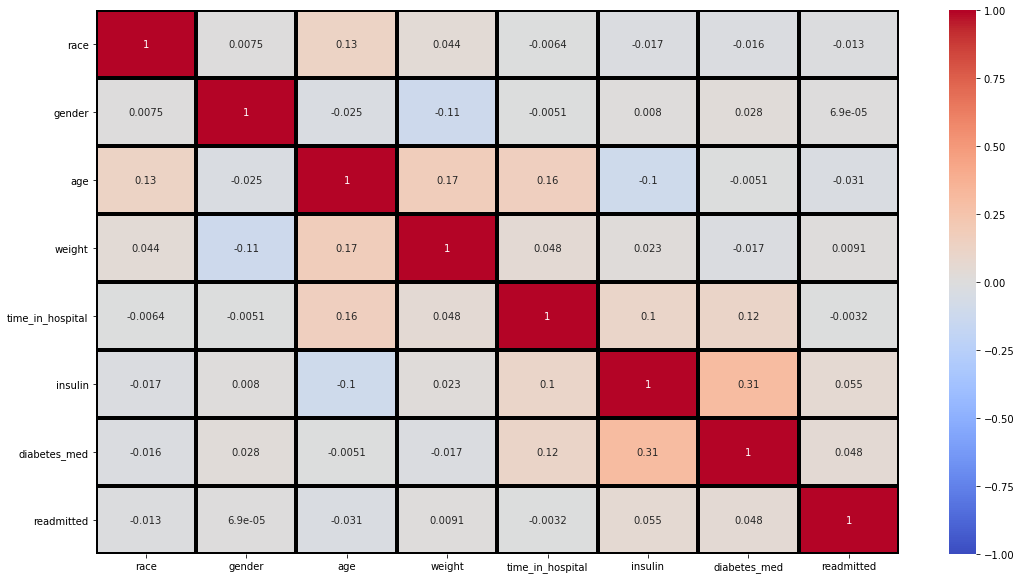

In [17]:
# Explore correlation between features via a heatmap
fix, ax = plt.subplots(figsize = (18, 10))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center =0, cmap = 'coolwarm', linewidths=3, linecolor='black',)

Looking at the correlation matrix, insulin and diabetesMed are slightly correlated (.31). However the relationship is not strong enough to warrant feature removal. Since no features are strongly correlated in our matrix, we can move ahead with our feature selection. 

In [22]:
df.to_csv("resources/final_data.csv")